In [160]:
from src.datasets.patch_tumor_classify_datamodule import BraTSDataModule
import yaml

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
%matplotlib inline


train loader data torch.Size([1, 4, 128, 128, 128])
train loader mask torch.Size([1, 3, 128, 128, 128])
train loader patch vols [torch.Size([1, 1, 64, 64, 64]), torch.Size([1, 1, 32, 32, 32]), torch.Size([1, 1, 16, 16, 16]), torch.Size([1, 1, 8, 8, 8]), torch.Size([1, 1, 4, 4, 4])]


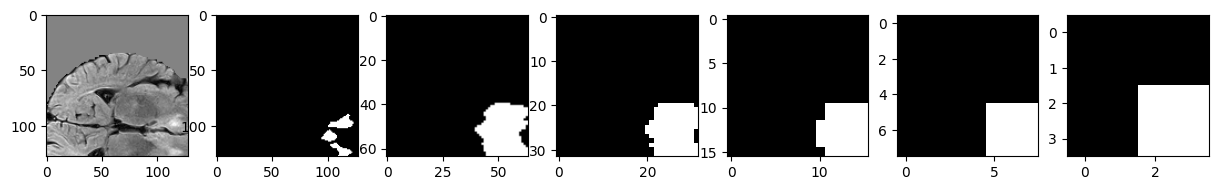

In [162]:
with open('/home/sanyal/Projects/BraTS3DDiff/configs/data/brats23_patch_tumor_classify.yaml') as f:
    cfg = yaml.safe_load(f)
cfg.pop('_target_')
cfg['data_dir'] = '/home/sanyal/Projects/BraTS3DDiff/data/BraTS-Data/BraTS2023-GLI'
cfg['patch_sizes'] = [2,4,8,16,32]
cfg['batch_size'] = 1
a = BraTSDataModule(**cfg)

train_data = a.train_dataloader()
data = iter(train_data).__next__()
image = data["image"]
print("train loader data", image.shape)
mask = data["mask"]
print("train loader mask", mask.shape)
b,c,w,h,d = mask.shape
patch_labels = data['patch_tumor_labels']
print("train loader patch vols", [patch_labels[i].shape for i in cfg['patch_sizes']])
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5))
axes[0].imshow(image[0,0,:,:,78],cmap='gray')
axes[1].imshow(mask[0,0,:,:,78],cmap='gray')
for i,(_,patch_label) in enumerate(patch_labels.items()):
    axes[i+2].imshow(patch_label[0,0,:,:,patch_label.shape[-1]//2],cmap='gray')

In [163]:
patch_label_32 = patch_labels[32]
patch_label_32.shape

torch.Size([1, 1, 4, 4, 4])

In [164]:
mask.shape

torch.Size([1, 3, 128, 128, 128])

In [165]:
pos_indices = patch_label_32.nonzero(as_tuple=True)
pos_indices

(metatensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 metatensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 metatensor([2, 2, 2, 2, 2, 3, 3, 3, 3, 3]),
 metatensor([2, 2, 3, 3, 3, 2, 2, 3, 3, 3]),
 metatensor([1, 2, 0, 1, 2, 1, 2, 0, 1, 2]))

In [166]:
patch_label_32.nonzero(as_tuple=False)


metatensor([[0, 0, 2, 2, 1],
        [0, 0, 2, 2, 2],
        [0, 0, 2, 3, 0],
        [0, 0, 2, 3, 1],
        [0, 0, 2, 3, 2],
        [0, 0, 3, 2, 1],
        [0, 0, 3, 2, 2],
        [0, 0, 3, 3, 0],
        [0, 0, 3, 3, 1],
        [0, 0, 3, 3, 2]])

In [167]:
pos_indices[0].shape

torch.Size([10])

In [169]:
mask_patches = mask.view(1,3,4,32,4,32,4,32)
mask_patches_pos = mask_patches[pos_indices[0], :, pos_indices[2], :,  pos_indices[3], :, pos_indices[4], :]
mask_patches_pos.shape

torch.Size([10, 3, 32, 32, 32])

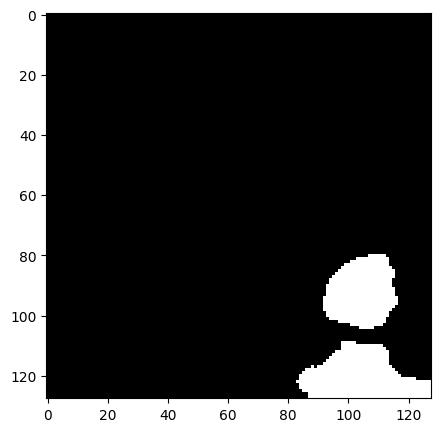

In [237]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow(mask[0,0,:,:,42],cmap='gray')

In [49]:
mask.shape

torch.Size([1, 3, 128, 128, 128])

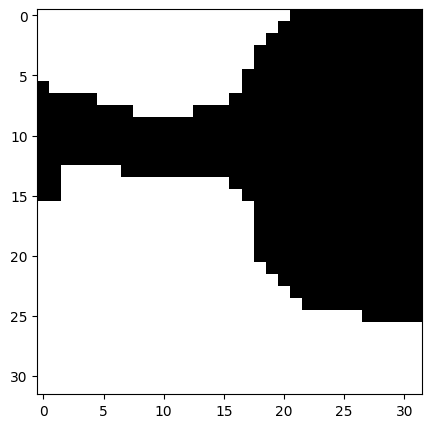

In [236]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow(mask_patches_pos[8,0,:,:,10],cmap='gray')

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow(mask_patches_pos[2,0,:,:,31],cmap='gray')

In [238]:
mask_patches_pos.shape

torch.Size([10, 3, 32, 32, 32])

In [239]:
fill_indices = torch.nonzero(patch_label_32, as_tuple=False)

fill_indices

metatensor([[0, 0, 2, 2, 1],
        [0, 0, 2, 2, 2],
        [0, 0, 2, 3, 0],
        [0, 0, 2, 3, 1],
        [0, 0, 2, 3, 2],
        [0, 0, 3, 2, 1],
        [0, 0, 3, 2, 2],
        [0, 0, 3, 3, 0],
        [0, 0, 3, 3, 1],
        [0, 0, 3, 3, 2]])

In [240]:
predicted_mask = torch.zeros((1, 3, 128, 128, 128))
P=32

# Iterate over fill_indices and scatter the predicted masks into the full tensor
for i in range(fill_indices.size(0)):
    b, _, w_idx, h_idx, d_idx = fill_indices[i]
    predicted_mask[b, :, w_idx * P:(w_idx + 1) * P,
                         h_idx * P:(h_idx + 1) * P,
                         d_idx * P:(d_idx + 1) * P] = mask_patches_pos[i].unsqueeze(0)

In [241]:
predicted_mask.shape

torch.Size([1, 3, 128, 128, 128])

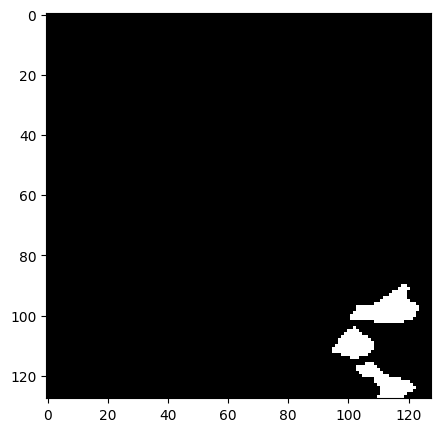

In [243]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow(mask[0,0,:,:,78],cmap='gray')

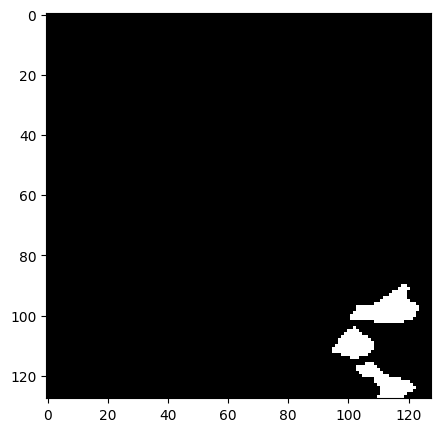

In [242]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
axes.imshow(predicted_mask[0,0,:,:,78],cmap='gray')

In [244]:
torch.equal(predicted_mask, mask)


True

In [40]:
import numpy as np
np.prod(list(predicted_mask.shape))

6291456

In [17]:
mask_patches.shape

torch.Size([1, 98304, 4, 4, 4])

In [12]:
list(enumerate(patch_labels.items()))predicted_mask[indices[0] :, indices[2] * P: (indices[2] + 1) * P, indices[3] * P: (indices[3] + 1) * P, indices[4] * P: (indices[4] + 1) * P] = patch_embeddings_extracted

[(0,
  (2, metatensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
   
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
   
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              ...,
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0., 0.,  ..., 0., 0., 0.]],
   
             ...,
   
             [[0., 0., 0.,  ..., 0., 0., 0.],
              [0., 0

In [13]:
patch_vol

metatensor([[[[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0275, 0.0028],
           [0.0000, 0.0908, 0.1560, 0.0358],
           [0.0000, 0.1642, 0.0012, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]]],


         [[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0083, 0.0000],
           [0.0000, 0.0000, 0.0009, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0

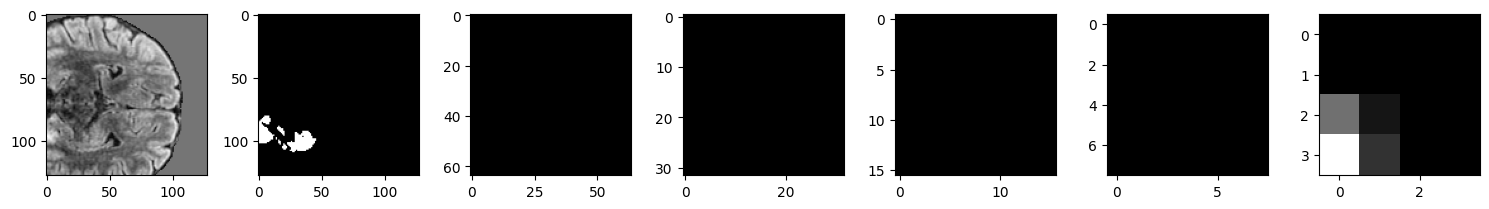

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5))
axes[0].imshow(image[0,0,:,:,78],cmap='gray')
axes[1].imshow(mask[0,0,:,:,78],cmap='gray')
for i,patch_vol in enumerate(patch_vols):
    axes[i+2].imshow(patch_vol[0,0,:,:,2],cmap='gray')


fig.tight_layout()

torch.Size([128, 128]) torch.Size([3, 128, 128])


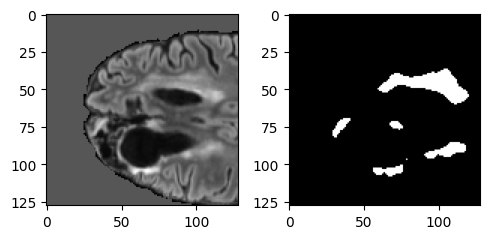

In [4]:
#visualize patches
im_channel=0
depth=78
image = image[0,im_channel,:,:,depth]
mask = mask[0,:,:,:,depth]
print(image.shape,mask.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask[0],cmap='gray')
fig.tight_layout()

train loader data torch.Size([1, 4, 128, 128, 128])
train loader mask torch.Size([1, 3, 128, 128, 128])
train loader patch vols [torch.Size([1, 1, 64, 64, 64]), torch.Size([1, 1, 32, 32, 32]), torch.Size([1, 1, 16, 16, 16]), torch.Size([1, 1, 8, 8, 8]), torch.Size([1, 1, 4, 4, 4])]
torch.Size([128, 128]) torch.Size([3, 128, 128])


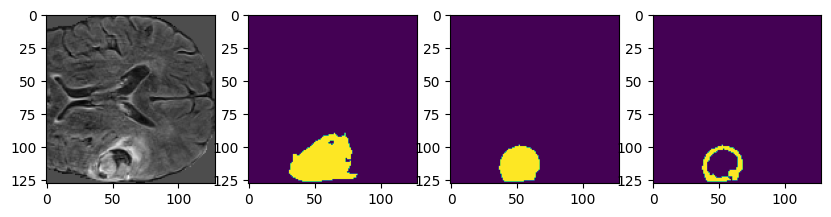

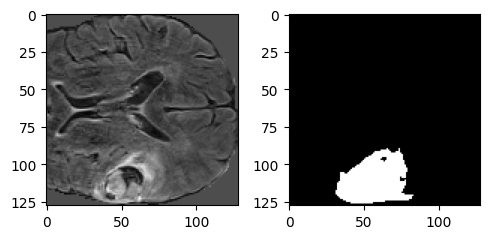

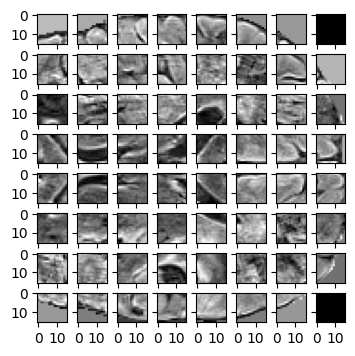

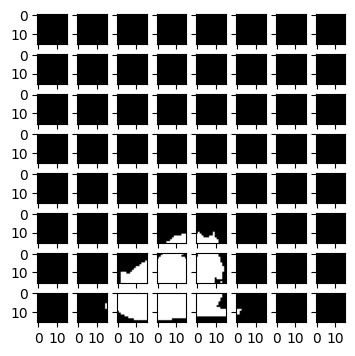

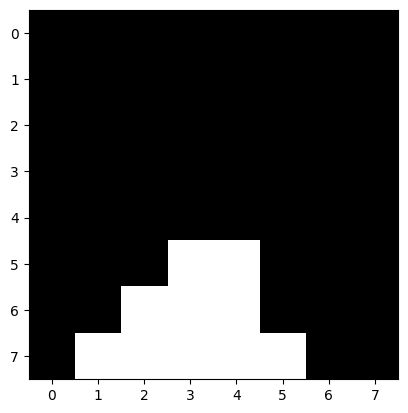

In [78]:
with open('/home/sanyal/Projects/BraTS3DDiff/configs/data/brats23_patch_tumor_classify.yaml') as f:
    cfg = yaml.safe_load(f)
cfg.pop('_target_')
cfg['data_dir'] = '/home/sanyal/Projects/BraTS3DDiff/data/BraTS-Data/BraTS2023-GLI'
cfg['patch_sizes'] = [2,4,8,16,32]
cfg['batch_size'] = 1
a = BraTSDataModule(**cfg)

train_data = a.train_dataloader()
data = iter(train_data).__next__()
image = data["image"]
print("train loader data", image.shape)
mask = data["mask"]
print("train loader mask", mask.shape)
b,c,w,h,d = mask.shape
patch_labels = data['patch_tumor_labels']
print("train loader patch vols", [patch_labels[i].shape for i in cfg['patch_sizes']])

#visualize patches
im_channel=0
depth=78
image = image[0,im_channel,:,:,depth]
mask = mask[0,:,:,:,depth]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axes[0].imshow(image,cmap='gray')
for i in range(1,4):
    axes[i].imshow(mask[i-1,:,:])
print(image.shape,mask.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask[0],cmap='gray')
fig.tight_layout()

w,h = image.shape
c,w,h = mask.shape
patch_size = cfg['patch_sizes'][-2]

img_patches = image.view(w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches_vol = mask_patches[0].sum(dim=(1,3))
mask_patches_vol[mask_patches_vol > 0] = 1
mask_patches_vol[mask_patches_vol == 0] = 0


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(img_patches[patch_index[0],:,patch_index[1],:],cmap='gray')

plt.show()
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(mask_patches[0, patch_index[0],:,patch_index[1],:],cmap='gray')
plt.show()

fig,ax = plt.subplots(1,1)
ax.imshow(mask_patches_vol,cmap='gray')

train loader data torch.Size([1, 4, 128, 128, 128])
train loader mask torch.Size([1, 3, 128, 128, 128])
train loader patch vols [torch.Size([1, 1, 64, 64, 64]), torch.Size([1, 1, 32, 32, 32]), torch.Size([1, 1, 16, 16, 16]), torch.Size([1, 1, 8, 8, 8]), torch.Size([1, 1, 4, 4, 4])]
torch.Size([128, 128]) torch.Size([3, 128, 128])


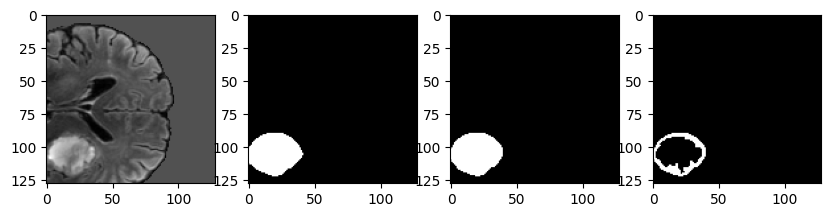

In [59]:
with open('/home/sanyal/Projects/BraTS3DDiff/configs/data/brats23_patch_tumor_classify.yaml') as f:
    cfg = yaml.safe_load(f)
cfg.pop('_target_')
cfg['data_dir'] = '/home/sanyal/Projects/BraTS3DDiff/data/BraTS-Data/BraTS2023-GLI'
cfg['patch_sizes'] = [2,4,8,16,32]
cfg['batch_size'] = 1
a = BraTSDataModule(**cfg)

train_data = a.train_dataloader()
data = iter(train_data).__next__()
image = data["image"]
print("train loader data", image.shape)
mask = data["mask"]
print("train loader mask", mask.shape)
b,c,w,h,d = mask.shape
patch_labels = data['patch_tumor_labels']
print("train loader patch vols", [patch_labels[i].shape for i in cfg['patch_sizes']])

#visualize patches
im_channel=0
depth=78
image = image[0,im_channel,:,:,depth]
mask = mask[0,:,:,:,depth]
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 5))
axes[0].imshow(image,cmap='gray')
for i in range(1,4):
    axes[i].imshow(mask[i-1,:,:],cmap='gray')
print(image.shape,mask.shape)



In [61]:
mask.shape


torch.Size([3, 128, 128])

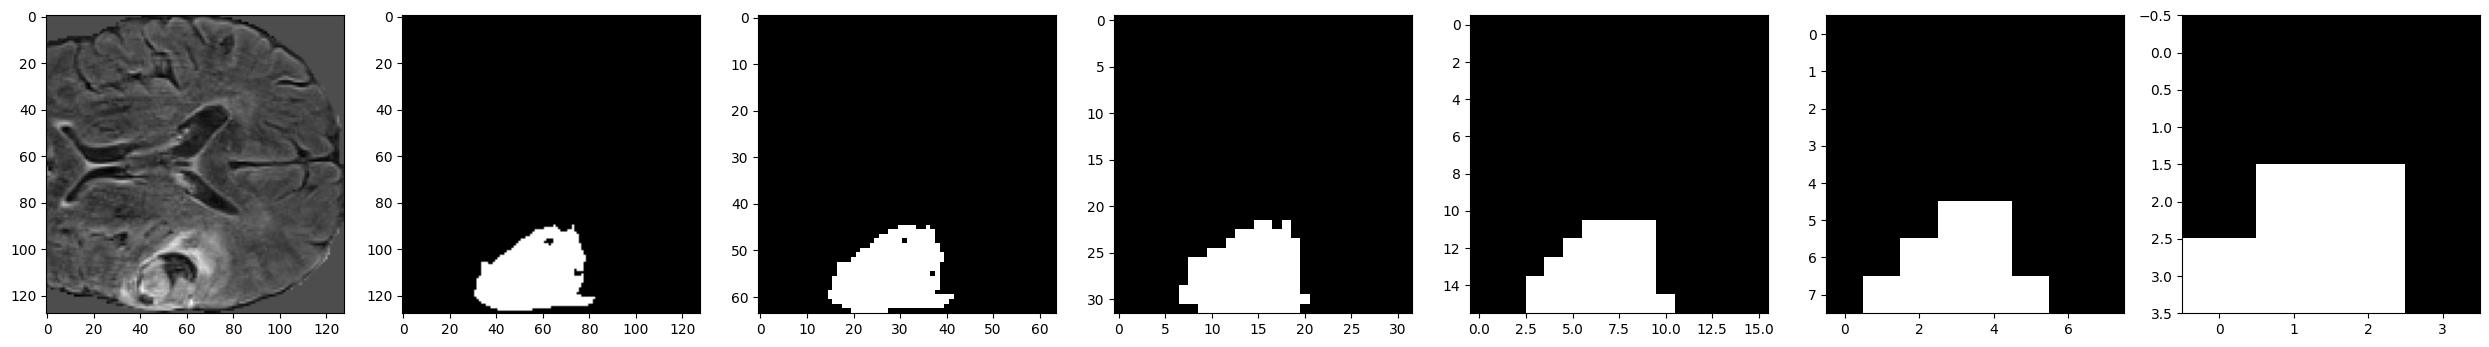

In [112]:
mask_0 = mask[0,:,:]
w,h = mask_0.shape

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(25, 10))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask_0,cmap='gray')
for i in range(len(cfg['patch_sizes'])):
    patch_size = cfg['patch_sizes'][i]
    mask_patches = mask_0.view(w//patch_size,patch_size,h//patch_size,patch_size)
    mask_patches_label = mask_patches.sum(dim=(1,3))
    mask_patches_label[mask_patches_label > 0] = 1
    mask_patches_label[mask_patches_label == 0] = 0

    axes[i+2].imshow(mask_patches_label,cmap='gray')


fig.tight_layout()

In [125]:
mask_patches_label.shape

torch.Size([4, 4])

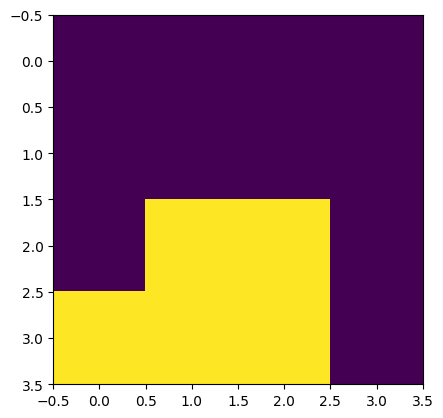

In [245]:
plt.imshow(mask_patches_label)

In [124]:
mask_patches_label

metatensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [1, 1, 1, 0]])

In [123]:
#filter indices
true_indices = mask_patches_label.nonzero(as_tuple=True)
true_indices

(metatensor([2, 2, 3, 3, 3]), metatensor([1, 2, 0, 1, 2]))

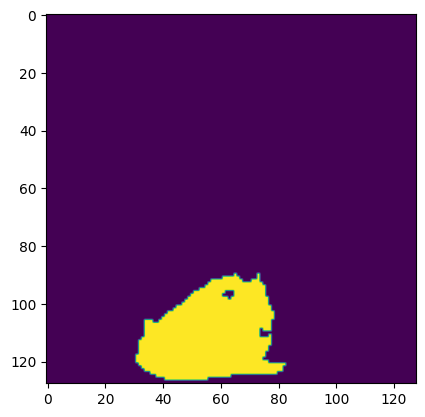

In [127]:
plt.imshow(mask_0)

In [129]:
mask_0.shape

torch.Size([128, 128])

In [254]:
mask_0_patches = mask_0.view(4,32,4,32).permute(1,3,0,2).contiguous().view(32*32,4,4)
mask_0_patches.shape

torch.Size([1024, 4, 4])

In [255]:
mask_0_patches_ = mask_0_patches.permute(1,2,0).contiguous()
mask_0_patches_.shape

torch.Size([4, 4, 1024])

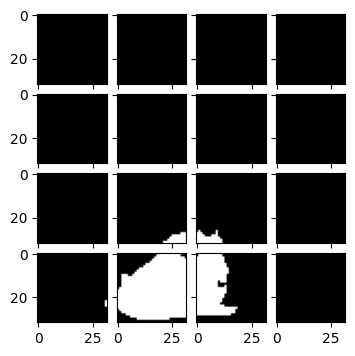

In [259]:
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (4, 4)
#downsample into 4x4 grid
mask_0_patches = mask_0.view(4,32,4,32)
#flatten grid
mask_0_patches_ = mask_0_patches.permute(0,2,1,3).contiguous().view(16,32,32)

#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    ax.imshow(mask_0_patches_[idx],cmap='gray')
plt.show()

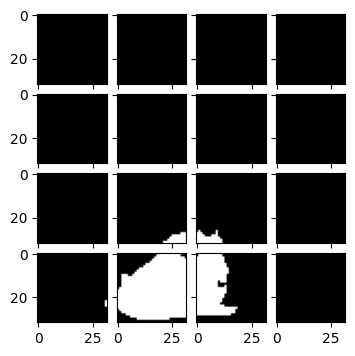

In [261]:
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (4, 4)
#downsample into 4x4 grid
mask_0_patches = mask_0.view(4,32,4,32)

#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(mask_0_patches[patch_index[0],:,patch_index[1],:],cmap='gray')
plt.show()

In [246]:
mask_patches_label

metatensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 1, 1, 0],
        [1, 1, 1, 0]])

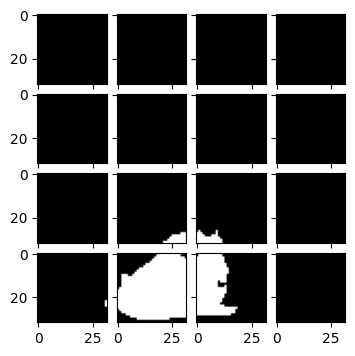

In [264]:
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(4, 4),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (4, 4)
mask_0_patches = mask_0.view(4,32,4,32)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(mask_0_patches[patch_index[0],:,patch_index[1],:],cmap='gray')
plt.show()

In [263]:
mask_patches_label.shape

torch.Size([4, 4])

In [265]:
mask_0_patches.shape

torch.Size([4, 32, 4, 32])

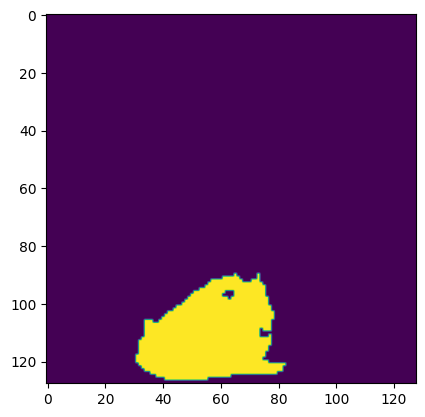

In [268]:
mask_0_ = mask_0_patches.view(128,128)
plt.imshow(mask_0_)

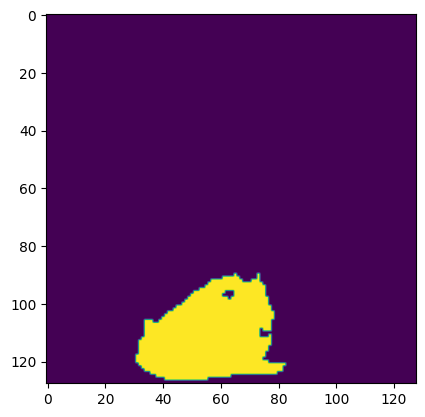

In [276]:
plt.imshow(mask_0_*x)

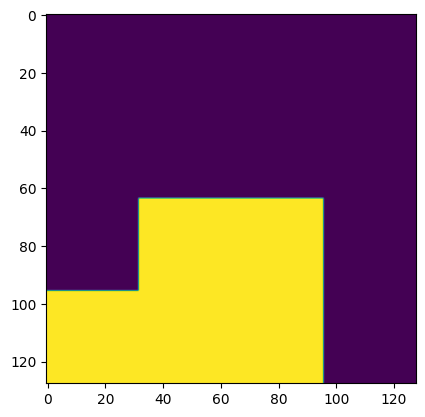

In [274]:
x=mask_patches_label.view(4,1,4,1).expand(4,32,4,32).contiguous().view(128,128)
plt.imshow(x)

In [130]:
#reshape mask_0
mask_0_patches = mask_0.view(4,32,4,32)
mask_0_patches.shape

torch.Size([4, 32, 4, 32])

In [277]:
true_indices

(metatensor([2, 2, 3, 3, 3]), metatensor([1, 2, 0, 1, 2]))

In [138]:
#subset mask_0_patches using true_indices
mask_0_patches_true = mask_0_patches[true_indices[0],:,true_indices[1],:]
mask_0_patches_true.shape

torch.Size([5, 32, 32])

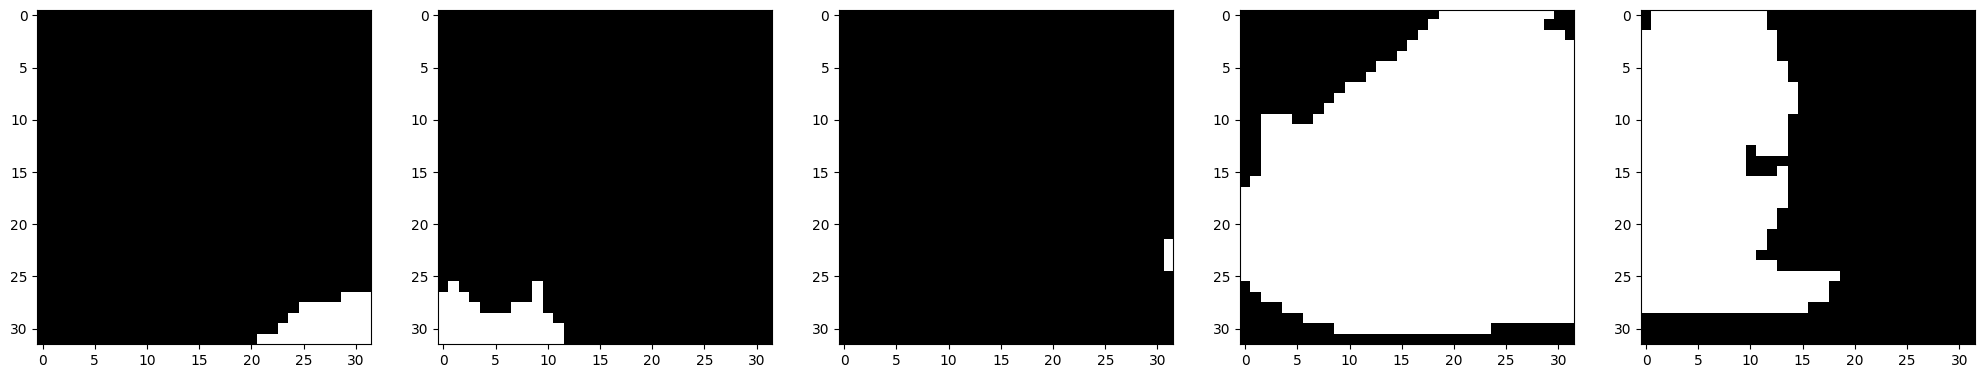

In [145]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 10))
for i in range(mask_0_patches_true.shape[0]):
    axes[i].imshow(mask_0_patches_true[i],cmap='gray')

In [149]:
true_indices

(metatensor([2, 2, 3, 3, 3]), metatensor([1, 2, 0, 1, 2]))

In [147]:
mask_0.shape

torch.Size([128, 128])

In [151]:
pred_mask_0 = torch.zeros((128,128))
pred_mask_0.shape

torch.Size([128, 128])

In [153]:
fill_indices = mask_patches_label.nonzero(as_tuple=False)
fill_indices

metatensor([[2, 1],
        [2, 2],
        [3, 0],
        [3, 1],
        [3, 2]])

In [154]:
for i in range(fill_indices.shape[0]):
    fill_idx = fill_indices[i]
    pred_mask_0[fill_idx[0]*32:(fill_idx[0]+1)*32,fill_idx[1]*32:(fill_idx[1]+1)*32] = mask_0_patches_true[i]

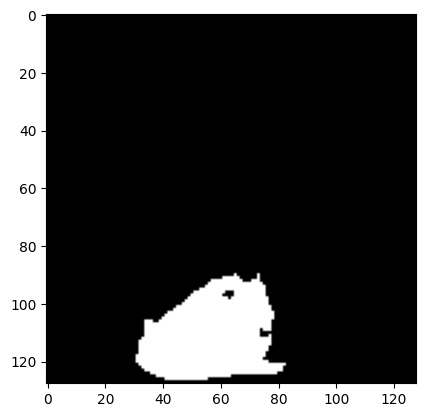

In [156]:
plt.imshow(pred_mask_0,cmap='gray')

In [157]:
torch.equal(pred_mask_0,mask_0)

True

In [69]:
mask_patches_label

metatensor([[0, 0, 0, 0],
        [0, 0, 0, 0],
        [1, 1, 0, 0],
        [1, 1, 0, 0]])

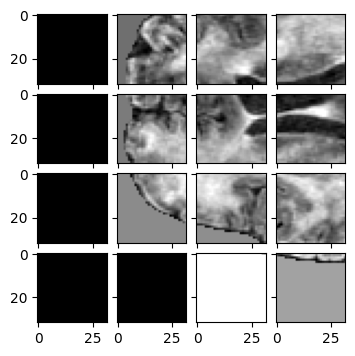

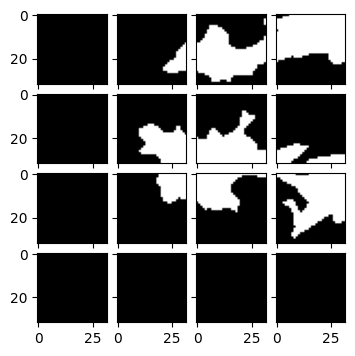

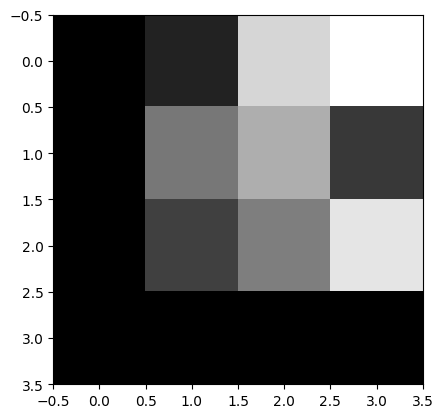

In [13]:
w,h = image.shape
c,w,h = mask.shape
patch_size = cfg['patch_sizes'][-1]

img_patches = image.view(w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches_vol = mask_patches[0].sum(dim=(1,3))/(patch_size*patch_size)


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(img_patches[patch_index[0],:,patch_index[1],:],cmap='gray')

plt.show()
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(mask_patches[0, patch_index[0],:,patch_index[1],:],cmap='gray')
plt.show()

fig,ax = plt.subplots(1,1)
ax.imshow(mask_patches_vol,cmap='gray')

In [14]:
mask_patches_vol

metatensor([[0.0000, 0.0830, 0.5166, 0.6172],
        [0.0000, 0.2891, 0.4209, 0.1377],
        [0.0000, 0.1553, 0.3047, 0.5537],
        [0.0000, 0.0000, 0.0000, 0.0000]])

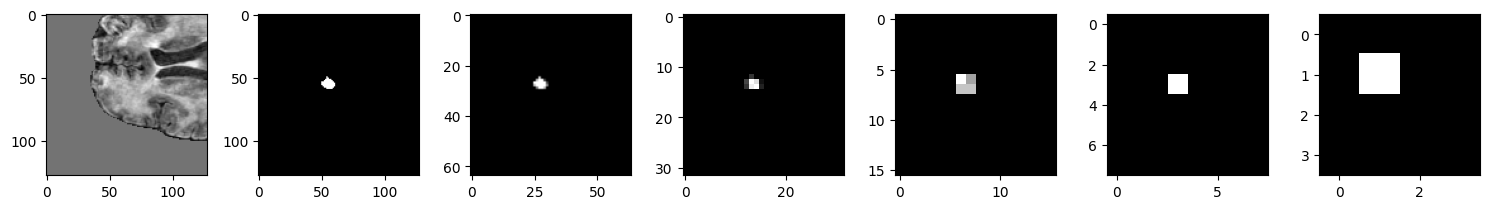

In [20]:


fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask[1],cmap='gray')
for i in range(len(cfg['patch_sizes'])):
    patch_size = cfg['patch_sizes'][i]
    mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
    mask_patches_vol = mask_patches[1].sum(dim=(1,3))
    axes[i+2].imshow(mask_patches_vol,cmap='gray')


fig.tight_layout()


In [21]:
mask_patches_vol

metatensor([[ 0,  0,  0,  0],
        [ 0, 70,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]])

In [17]:
mask.shape

torch.Size([3, 128, 128])

In [7]:
patch_size=32
mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches_vol = mask_patches[0].sum(dim=(1,3))

In [8]:
mask_patches_vol

metatensor([[  0,  85, 529, 632],
        [  0, 296, 431, 141],
        [  0, 159, 312, 567],
        [  0,   0,   0,   0]])

In [10]:
32*32

1024

In [ ]:
mask_patches_vol